In [216]:
## Question 7
from urllib.parse import urlparse
from shapely.geometry import Point
from geopandas.tools import sjoin
from sklearn.neighbors import KernelDensity
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
from libpysal.weights import Queen
from esda.moran import Moran
from esda.moran import Moran_Local
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import hdbscan

# load the data
file_path = 'cleaned_data_2023.csv'
df = pd.read_csv(file_path)


#filter out ghost room data (room_type=Private room)
filtered_data = df[df['room_type'] == 'Private room']
# get 13375 ghost room data of 37242 data
#Then tranform coordinate into point and make it GeoDataframe
df_with_coordinates = pd.DataFrame(filtered_data)
geometry = [Point(lon, lat) for lon, lat in zip(df_with_coordinates['longitude'], df_with_coordinates['latitude'])]
gdf_with_coordinates = gpd.GeoDataFrame(df_with_coordinates, geometry=geometry, crs="EPSG:4326")


In [217]:
# Then we load London ward
def cache_data(source_url, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
        
    filename = source_url.split('/')[-1].split('?')[0]  # 假设URL以文件名结尾
    file_path = os.path.join(dest_dir, filename)
    
    if not os.path.isfile(file_path):
        response = requests.get(source_url)
        if response.status_code == 200:
            with open(file_path, 'wb') as file:
                file.write(response.content)
        else:
            raise Exception(f"Failed to download {source_url}")

    return file_path
london_map = gpd.read_file(
    cache_data('https://github.com/ZhengyongLiu/FSDS_GroupAssignment_Data/blob/main/Borough/London_Borough_Excluding_MHW.zip?raw=true', 
               os.path.join('data','geo')), driver='ESRI Shapefile')
london_vector_map = london_map.to_crs('EPSG:4326')
# spatial connection 
merged_gdf = gpd.sjoin(gdf_with_coordinates, london_vector_map, how='left', op='within')

print(merged_gdf)

                       id last_scraped    host_id host_name host_is_superhost  \
0                   92644   2023-09-06     498201   Dee Dee                 f   
2                   13913   2023-09-06      54730     Alina                 f   
4                   93734   2023-09-07     497514   William                 t   
7                   96052   2023-09-06     448154     Aneta                 f   
9                   97506   2023-09-07     497537     Maria                 f   
...                   ...          ...        ...       ...               ...   
37230  968783496505858173   2023-09-06  534493799    Amanda                 f   
37231  968803060946575409   2023-09-06  534516902     Irena                 f   
37236  970100852579649966   2023-09-06   24366284   Claudia                 f   
37240  971887875299343051   2023-09-06  320860309    Khalid                 f   
37241  972316487904830732   2023-09-06  433303389      Bora                 f   

       host_listings_count 

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

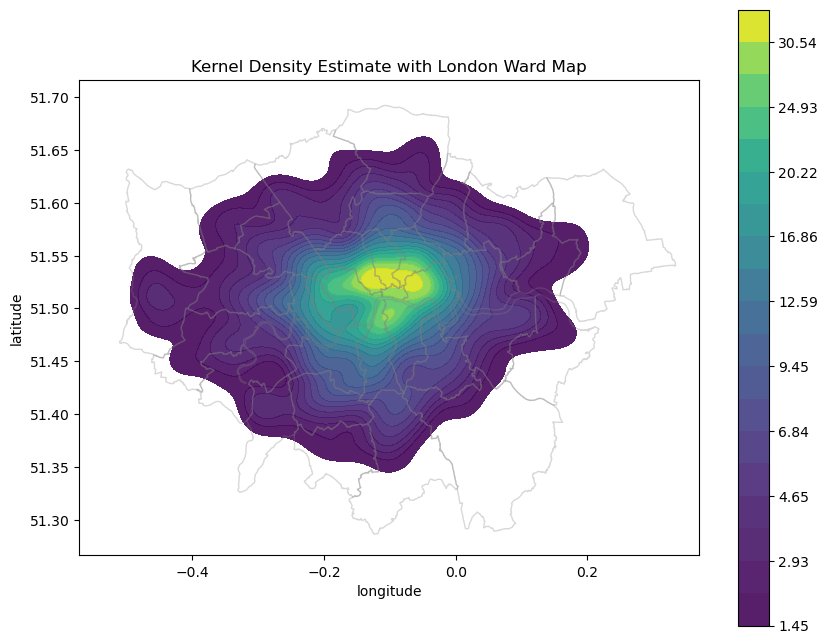

In [218]:
# Next step we do the KDE analysis
plt.figure(figsize=(10, 8))
sns.kdeplot(
    data=merged_gdf,
    x='longitude',
    y='latitude',
    fill=True,
    cmap='viridis',
    cbar=True,
    levels=20,  # Adjust contour levels as needed,
    alpha=0.9
)

london_vector_map.plot(ax=plt.gca(), color='none', edgecolor='grey',alpha=0.3)

# set the map title
plt.title('Kernel Density Estimate with London Ward Map')
plt.show()

<Figure size 1200x1000 with 0 Axes>

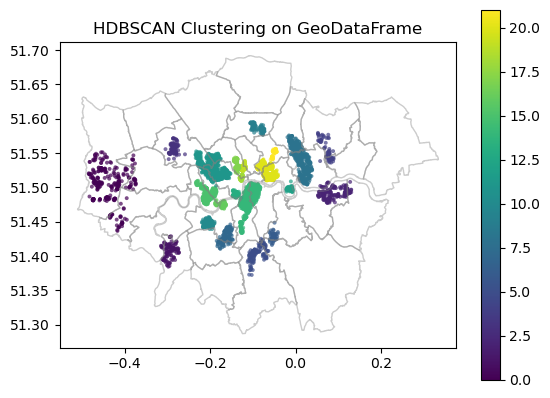

Number of clusters: 23


In [224]:
# Next step we do the HDBscan
# create feature dataframe
features = merged_gdf[['longitude', 'latitude']]
HDBscan = hdbscan.HDBSCAN(min_cluster_size=50, metric='haversine')

# cluster the feature
clusters = HDBscan.fit_predict(features)

# add cluster results into GeoDataFrame 
merged_gdf['cluster'] = clusters
# Filtering out clustered points.
clustered_points = merged_gdf[merged_gdf['cluster'] != -1]

# draw the map
plt.figure(figsize=(12,10))
clustered_points.plot(column= 'cluster', cmap='viridis', legend=True, markersize=8, edgecolor='none', alpha=0.7)
plt.title('HDBSCAN Clustering on GeoDataFrame')
london_vector_map.plot(ax=plt.gca(), color='none', edgecolor='grey',alpha=0.4)
plt.show()
# show the cluster amount
num_clusters = merged_gdf['cluster'].nunique()
print("Number of clusters:", num_clusters)

In [121]:
#Then we try Global Moran's I
# 创建 Queen 空间权重矩阵
w = Queen.from_dataframe(merged_gdf)
variable_columns = ['host_listings_count', 'host_total_listings_count', 'accommodates','review_scores_rating','number_of_reviews','maximum_nights','latitude'
                   ,'longitude']
for variable in variable_columns:
    # 提取变量
    your_variable = merged_gdf[variable]

    # 计算莫兰指数
    moran_global = Moran(your_variable, w)
    print(f"Global Moran's I for {variable}: {moran_global.I}")
# 绘制空间分布图
#fig, ax = plt.subplots(figsize=(10, 8))
#merged_gdf.plot(column='moran_global', cmap='viridis', legend=True, ax=ax)
#plt.title('Spatial Distribution')
#plt.show()

/opt/conda/lib/python3.11/site-packages/libpysal/cg/voronoi.py:173: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  region_df["geometry"] = [Polygon(vertices[region]) for region in regions]
/opt/conda/lib/python3.11/site-packages/libpysal/cg/voronoi.py:176: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_

Global Moran's I for host_listings_count: 0.4796476134632808
Global Moran's I for host_total_listings_count: 0.4989577083390955
Global Moran's I for accommodates: 0.11401037576111887
Global Moran's I for review_scores_rating: 0.09836214490725387
Global Moran's I for number_of_reviews: 0.12775850589080495
Global Moran's I for maximum_nights: -7.704317001774485e-05
Global Moran's I for latitude: 0.9978063047873535
Global Moran's I for longitude: 0.9993659598690849


In [124]:
# 取gdf离自己距离最近的点
from scipy.spatial.distance import cdist

coords = merged_gdf['geometry'].apply(lambda point: (point.x, point.y)).to_list()

# 使用 cdist 计算两两点之间的距离
distances = cdist(coords, coords, metric='euclidean')

# 将对角线上的距离设置为无穷大，避免计算到自身的距离
np.fill_diagonal(distances, np.inf)

# 获取每个点的最近距离
nearest_distances = distances.min(axis=1)

# 将 'nearest_distance' 列添加到 GeoDataFrame 中
merged_gdf['nearest_distance'] = nearest_distances

# 打印结果或进行其他处理
print(merged_gdf[['geometry', 'nearest_distance']])

                        geometry  nearest_distance
0      POINT (-0.18739 51.44201)          0.000881
2      POINT (-0.11270 51.56861)          0.001550
4       POINT (0.01442 51.47618)          0.002519
7      POINT (-0.22497 51.55930)          0.000812
9      POINT (-0.12161 51.42996)          0.001577
...                          ...               ...
37230  POINT (-0.13503 51.46854)          0.001941
37231  POINT (-0.23828 51.50190)          0.000601
37236  POINT (-0.09992 51.52452)          0.000525
37240  POINT (-0.07025 51.50923)          0.000726
37241  POINT (-0.19357 51.44489)          0.000763

[13375 rows x 2 columns]


/opt/conda/lib/python3.11/site-packages/esda/crand.py:328: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  rstats = stat_func(chunk_start + i, z, permuted_ids, weights_i, scaling)
/opt/conda/lib/python3.11/site-packages/esda/crand.py:328: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  rstats = stat_func(chunk_start + i, z, permuted_ids, weights_i, scaling)
/opt/con

0       -0.923953
2        0.952161
4        0.574058
7       -0.762460
9       -0.094456
           ...   
37230   -0.346805
37231   -0.684865
37236   -0.481677
37240   -0.910490
37241    0.344736
Name: z_scores, Length: 13375, dtype: float64
最小z-score值: -3.140191829470507
最大z-score值: 26.771422323284213


<Figure size 1000x800 with 0 Axes>

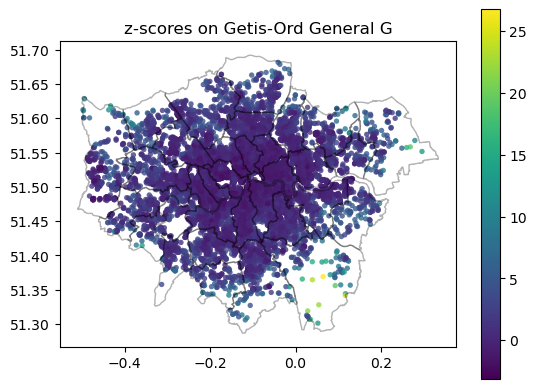

In [175]:
#冷热点分析 Getis-Ord General G 
from esda.getisord import G_Local
from splot.esda import plot_local_autocorrelation
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming 'merged_gdf' is a GeoDataFrame and 'nearest_distance' is the variable of interest
variable_of_interest = merged_gdf['nearest_distance']

# 'w' is assumed to be a spatial weights matrix, which defines the spatial relationships between observations

# Calculate Getis-Ord General G statistic
g_local = G_Local(variable_of_interest, w)

# Get Z-scores and p-values from the calculation
z_scores = g_local.z_sim
p_values = g_local.p_sim

merged_gdf['z_scores']=z_scores
print(merged_gdf['z_scores'])


#重新将Z值分类

# 假设 'merged_gdf' 是您的 GeoDataFrame，'z_scores' 是标准分数的列
z_scores = merged_gdf['z_scores']

# 定义分箱边界，可以根据实际情况调整
bins = [-float('inf'), -1.96, 1.96, float('inf')]

# 使用cut函数将数据分为三个类别
categories = pd.cut(z_scores, bins, labels=['Low', 'Medium', 'High'])

# 将类别赋值给 GeoDataFrame 中的新列
merged_gdf['z_score_categories'] = categories

# 打印结果
print(merged_gdf[['z_scores', 'z_score_categories']])


#map
plt.figure(figsize=(10, 8))
merged_gdf.plot(column='z_scores', cmap='viridis',  markersize=15,legend=True  ,edgecolor='none', alpha=0.8, )
plt.title('z-scores on Getis-Ord General G')
london_vector_map.plot(ax=plt.gca(), color='none', legend=True,edgecolor='black',alpha=0.3)
plt.show()


In [147]:
#全局莫兰指数

# 创建 Queen 空间权重矩阵
w = Queen.from_dataframe(merged_gdf)

# 选择你感兴趣的变量列
variable_of_interest = merged_gdf['nearest_distance']

# 计算全局莫兰指数
moran_global = Moran(variable_of_interest, w)

# 打印全局莫兰指数
print("Global Moran's I:", moran_global.I)

/opt/conda/lib/python3.11/site-packages/libpysal/cg/voronoi.py:173: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  region_df["geometry"] = [Polygon(vertices[region]) for region in regions]
/opt/conda/lib/python3.11/site-packages/libpysal/cg/voronoi.py:176: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_

Global Moran's I: 0.43858977488555656
